In [3]:
from keras import Model
from keras.layers import *
from keras.utils import plot_model
import keras.backend as K
import os
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.saving import save_model, load_model
from keras import regularizers

In [2]:
BATCH_SIZE = 10
EPOCHS = 6

In [3]:
def model_network():
    x = Input(shape=(256, 256, 1), batch_size=BATCH_SIZE)
    # conv1 = Conv2D(activation="relu", kernel_size=(10, 10), filters=64)(x)
    # maxpool1 = MaxPooling2D()(conv1)
    # conv2 = Conv2D(activation="relu", kernel_size=(7, 7), filters=128)(maxpool1)
    # maxpool2 = MaxPooling2D()(conv2)
    # conv3 = Conv2D(activation="relu", kernel_size=(4, 4), filters=128)(x)
    # maxpool3 = MaxPooling2D()(conv3)
    # conv4 = Conv2D(activation="relu", kernel_size=(4, 4), filters=256)(maxpool3)
    # flattened = Flatten()(conv4)
    # dense1 = Dense(4096)(flattened)

    conv3 = Conv2D(activation="relu", kernel_size=(11, 11), filters=16, kernel_regularizer=regularizers.l2(0.003))(x)
    maxpool3 = MaxPooling2D()(conv3)
    conv4 = Conv2D(activation="relu", kernel_size=(7, 7), filters=32)(maxpool3)
    maxpool4 = MaxPooling2D()(conv4)
    conv4 = Conv2D(activation="relu", kernel_size=(4, 4), filters=64)(maxpool4)
    flattened = Flatten()(conv4)
    dense1 = Dense(1024, activation="relu")(flattened)

    return (x, dense1)

In [4]:
upper_layer = model_network()
lower_layer = model_network()

In [5]:
lambda_layer = Lambda(lambda x: (K.square(x[0] - x[1])))([upper_layer[1], lower_layer[1]])
dense_final = Dense(1, activation="sigmoid")(lambda_layer)

model = Model(inputs=[upper_layer[0], lower_layer[0]], outputs=[dense_final])

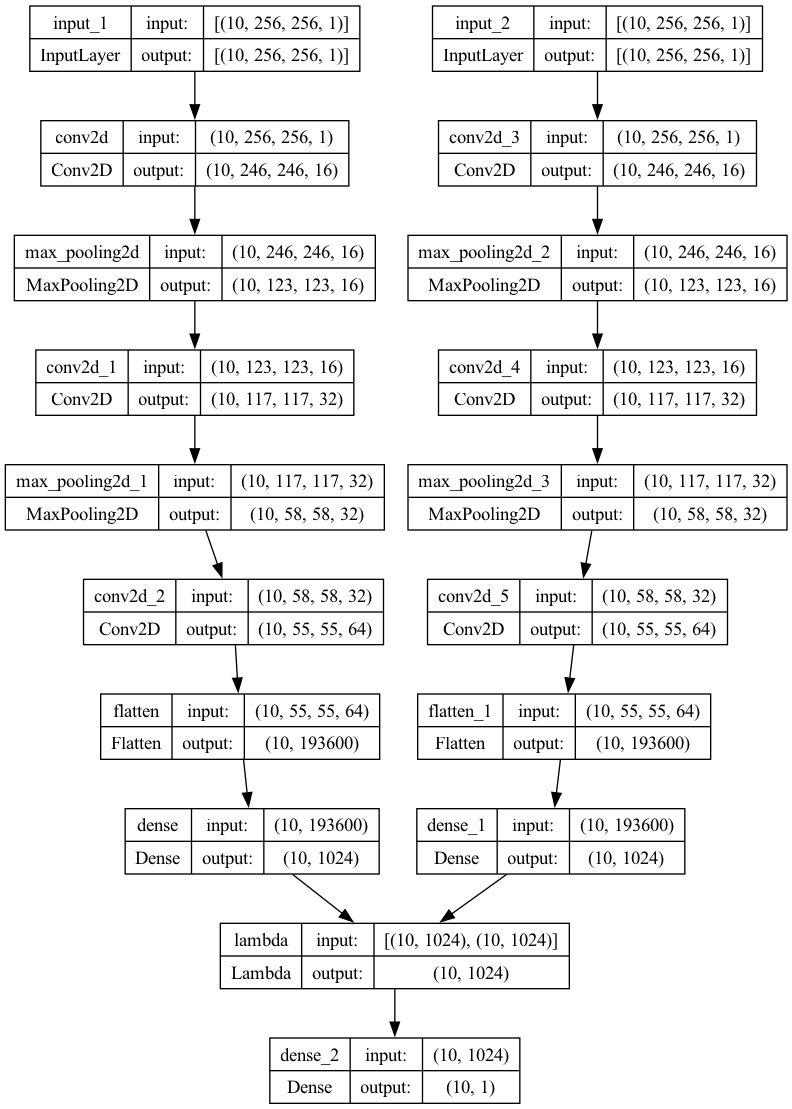

In [6]:
plot_model(model, show_shapes=True)

In [7]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [8]:
def get_grayscaled_roi(folder_name, to_save_to):
    i = 0
    images = os.listdir(folder_name)
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

    for i, img in enumerate(tqdm(images)):
        if(img.startswith(".") == False):
            try:
                frame = cv2.imread(f"{folder_name}/{img}")
                gray = cv2.cvtColor(src = frame, code = cv2.COLOR_BGR2GRAY)
                faces = face_cascade.detectMultiScale(image = gray, scaleFactor=1.3, minNeighbors=5)
                (x,y,w,h) = faces[0]
                grayscaled_roi = gray[y:y+h, x:x+w]                
                gray = cv2.resize(grayscaled_roi, (256, 256))

                cv2.imwrite(f"{to_save_to}/{i}.png", img = gray)
                i += 1
            except Exception as e:
                print(",", end = ',')

In [9]:
get_grayscaled_roi("negative_real", "negative_grayed")
get_grayscaled_roi("positive_real", "positive_grayed")
get_grayscaled_roi("anchor_real", "anchor_grayed")

 18%|█▊        | 26/142 [00:00<00:01, 109.52it/s]

,,,,,,,,,,,,,,,,,,

 74%|███████▍  | 105/142 [00:00<00:00, 216.27it/s]

,,,,,,,,,,,,,,

100%|██████████| 142/142 [00:00<00:00, 189.03it/s]


,,

 11%|█▏        | 9/80 [00:00<00:02, 27.23it/s]

,,

 61%|██████▏   | 49/80 [00:01<00:00, 32.20it/s]

,,

100%|██████████| 80/80 [00:02<00:00, 29.38it/s]


,,,,

 38%|███▊      | 30/79 [00:00<00:01, 30.95it/s]

,,

 58%|█████▊    | 46/79 [00:01<00:01, 30.42it/s]

,,,,

 89%|████████▊ | 70/79 [00:02<00:00, 31.10it/s]

,,

100%|██████████| 79/79 [00:02<00:00, 30.70it/s]


In [10]:
print("Length of positive data", len(os.listdir("positive_grayed")))
print("Length of negative data", len(os.listdir("negative_grayed")))
print("Length of anchor data", len(os.listdir("anchor_grayed")))

Length of positive data 75
Length of negative data 124
Length of anchor data 74


In [11]:
def convert_to_img_data(dir):
    data = []
    for i in os.listdir(dir):
        image = np.array(cv2.imread(os.path.join(dir, i), flags = cv2.IMREAD_GRAYSCALE))
        data.append(image/255)
    
    return data

In [12]:
positive_data = convert_to_img_data("positive_grayed")
negative_data = convert_to_img_data("negative_grayed")
anchor_data = convert_to_img_data("anchor_grayed")

In [13]:
valid = list(zip(positive_data, anchor_data[0:len(positive_data)], [1]*len(positive_data)))
invalid = list(zip(negative_data, anchor_data[0:len(negative_data)], [0]*len(negative_data)))

In [14]:
print("Length of matching data", len(valid))
print("Length of invalid data", len(invalid))

Length of matching data 74
Length of invalid data 74


In [15]:
a = int(0.8*(len(valid)))
train_data = []
cv_data = []

train_data.extend(valid[:a])
train_data.extend(invalid[:a])
cv_data.extend(valid[a:])
cv_data.extend(invalid[a:])

In [16]:
print(len(train_data))
print(len(cv_data))

118
30


In [17]:
first_input = []
second_input = []
third_label = []

first_input_cv = []
second_input_cv = []
third_label_cv = []

for i in train_data:
    first_input.append(i[0])
    second_input.append(i[1])
    third_label.append(i[2])

for i in cv_data:
    first_input_cv.append(i[0])
    second_input_cv.append(i[1])
    third_label_cv.append(i[2])

In [18]:
model.fit([np.array(first_input), np.array(second_input)], np.array(third_label), epochs=EPOCHS, verbose=1, batch_size=BATCH_SIZE, validation_data=([np.array(first_input_cv), np.array(second_input_cv)], np.array(third_label_cv)))
model.save("model_final.h5")

Epoch 1/6
12/12 [==============================] - 70s 6s/step - loss: 6.3189 - accuracy: 0.5678 - val_loss: 1.2240 - val_accuracy: 0.5000
Epoch 2/6
12/12 [==============================] - 74s 6s/step - loss: 0.6825 - accuracy: 0.6441 - val_loss: 1.0446 - val_accuracy: 0.8000
Epoch 3/6
12/12 [==============================] - 58s 5s/step - loss: 0.8916 - accuracy: 0.7458 - val_loss: 1.0043 - val_accuracy: 0.5333
Epoch 4/6
12/12 [==============================] - 77s 6s/step - loss: 0.5261 - accuracy: 0.8305 - val_loss: 0.4093 - val_accuracy: 0.8333
Epoch 5/6
12/12 [==============================] - 80s 7s/step - loss: 0.3470 - accuracy: 0.8983 - val_loss: 0.3937 - val_accuracy: 0.8333
Epoch 6/6
12/12 [==============================] - 76s 6s/step - loss: 0.2179 - accuracy: 0.9237 - val_loss: 0.2895 - val_accuracy: 0.8667


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
plt.plot(model.history.history['loss'], color='b', label = "Train Loss")
plt.plot(model.history.history['val_loss'], color='r', label = "Validation loss")

plt.title("Loss Analysis")
plt.xlabel("epochs")
plt.ylabel("Loss")

plt.legend("x")

plt.show()


NameError: name 'plt' is not defined

In [ ]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
img1 = cv2.imread("positive_grayed/1.png", flags = cv2.IMREAD_GRAYSCALE)
mat = cv2.imread("s1.png", flags = cv2.IMREAD_GRAYSCALE)
faces = face_cascade.detectMultiScale(image = mat, scaleFactor=1.3, minNeighbors=5)

if (len(faces) > 0):
    (x, y, w, h) = faces[0]

    mat = mat[y:y+h, x:x+w]
    mat = cv2.resize(src = mat, dsize=(256, 256))

    img1 = cv2.resize(src = img1, dsize=(256, 256))
    img1 = img1 / 255
    img1 = img1[None, :]

    mat = mat / 255
    mat = mat[None, :]
    
    value = model.predict([mat, img1])[0][0]
    if(value > 0.5):
        print("Yes")
    else:
        print("No")
else:
    print("No Face Detected")

In [4]:
# model = load_model("model_final.h5")

In [5]:
def predict_live(image_person):    
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    video = cv2.VideoCapture(0)

    mat = cv2.imread(image_person, flags = cv2.IMREAD_GRAYSCALE)
    faces = face_cascade.detectMultiScale(image = mat, scaleFactor=1.3, minNeighbors=5)
    (x, y, w, h) = faces[0]

    mat = mat[y:y+h, x:x+w]
    mat = cv2.resize(mat, (256, 256))

    mat = mat / 255
    mat = mat[None, :, :, None]

    while video.isOpened():
        ret, frame = video.read()

        if ret:
            try:
                gray = cv2.cvtColor(src = frame, code = cv2.COLOR_BGR2GRAY)

                faces = face_cascade.detectMultiScale(image = gray, scaleFactor=1.3, minNeighbors=5) 

                if(len(faces) > 0):
                    (x, y, w, h) = faces[0]
                    gray = gray[y:y+h, x:x+w]

                    graying = cv2.resize(gray, (256, 256))
                    graying = graying / 255

                    graying = graying[None, :, :, None]
                    
                    value = model.predict([graying, mat])

                    if(value > 0.5):
                        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
                    else:
                        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)
                    cv2.imshow(winname = 'Face Detection', mat = np.array(frame))

                    print(value)

                    if(cv2.waitKey(1) == ord('a')):
                        cv2.destroyAllWindows()
                else:
                    cv2.imshow(winname = 'Face Detection', mat = np.array(frame))
                    cv2.putText(np.array(frame), 'Checking Faces...', (50, 50), 1,  
                    1, (255, 0, 0) , 3, cv2.LINE_AA)
                    if(cv2.waitKey(1) == ord('a')):
                        cv2.destroyAllWindows()

            except Exception as e:
                cv2.imshow(winname = 'Face Detection', mat = np.array(frame))
                print(e)

In [6]:
predict_live("positive_real/00279dfe-b4a1-11ee-ba8d-1eebf6296962.png")

1/1 [==============================] - 2s 2s/step
[[0.60362107]]
1/1 [==============================] - 0s 477ms/step
[[0.99466157]]


1   HIToolbox                           0x000000018ddd05c8 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 120
2   HIToolbox                           0x000000018ddd0188 _ZN15MenuBarInstance14EnableAutoShowEv + 60
3   HIToolbox                           0x000000018dd73310 SetMenuBarObscured + 372
4   HIToolbox                           0x000000018dd72ee8 _ZN13HIApplication15HandleActivatedEP14OpaqueEventRefhP15OpaqueWindowPtrh + 172
5   HIToolbox                           0x000000018dd6cfcc _ZN13HIApplication13EventObserverEjP14OpaqueEventRefPv + 296
6   HIToolbox                           0x000000018dd33cd0 _NotifyEventLoopObservers + 176
7   HIToolbox                           0x000000018dd6c96c AcquireEventFromQueue + 432
8   HIToolbox                           0x000000018dd5bc84 ReceiveNextEventCommon + 320
9   HIToolbox                           0x000000018dd5bb2c _BlockUntilNextEventMatchingListInModeWithFilter + 72
10  AppKit                              0x000000018790184c _DPS

1/1 [==============================] - 1s 536ms/step
[[0.9947859]]
1/1 [==============================] - 0s 201ms/step
[[0.99482214]]
1/1 [==============================] - 0s 78ms/step
[[0.9917974]]
1/1 [==============================] - 0s 79ms/step
[[0.9861661]]
1/1 [==============================] - 0s 72ms/step
[[0.9910431]]
1/1 [==============================] - 0s 69ms/step
[[0.99136364]]
1/1 [==============================] - 0s 70ms/step
[[0.9896398]]
1/1 [==============================] - 0s 70ms/step
[[0.99205434]]
1/1 [==============================] - 0s 90ms/step
[[0.99051696]]
1/1 [==============================] - 0s 71ms/step
[[0.9921658]]
1/1 [==============================] - 0s 75ms/step
[[0.9919096]]
1/1 [==============================] - 0s 70ms/step
[[0.9922261]]
1/1 [==============================] - 0s 74ms/step
[[0.9910597]]
1/1 [==============================] - 0s 68ms/step
[[0.9927369]]
1/1 [==============================] - 0s 88ms/step
[[0.99158096]]
1/1

1   HIToolbox                           0x000000018dd5b90c _ZN15MenuBarInstance22RemoveAutoShowObserverEv + 44
2   HIToolbox                           0x000000018dd3d8c8 _ZN15MenuBarInstance21UpdateAggregateUIModeE21MenuBarAnimationStylehhh + 1196
3   HIToolbox                           0x000000018dd3d30c _ZN15MenuBarInstance16ForEachMenuBarDoEU13block_pointerFvPS_E + 72
4   HIToolbox                           0x000000018dd3d2b4 _ZL25UpdateAllAggregateUIModes21MenuBarAnimationStyleh + 120
5   HIToolbox                           0x000000018dd3d228 SetSystemUIMode + 140
6   AppKit                              0x0000000187bbfd40 -[NSApplication _setPresentationOptions:instance:flags:] + 972
7   AppKit                              0x0000000187a55954 -[NSApplication _updateFullScreenPresentationOptionsForInstance:] + 428
8   CoreFoundation                      0x0000000184672560 __CFNOTIFICATIONCENTER_IS_CALLING_OUT_TO_AN_OBSERVER__ + 148
9   CoreFoundation                      0x0000000184

1/1 [==============================] - 0s 275ms/step
[[0.9953558]]
1/1 [==============================] - 0s 267ms/step
[[0.9954329]]
1/1 [==============================] - 0s 103ms/step
[[0.9926873]]
1/1 [==============================] - 0s 89ms/step
[[0.99494475]]
1/1 [==============================] - 0s 436ms/step
[[0.9941651]]
1/1 [==============================] - 0s 136ms/step
[[0.9960599]]
1/1 [==============================] - 0s 75ms/step
[[0.99540967]]
1/1 [==============================] - 0s 69ms/step
[[0.99544275]]
1/1 [==============================] - 0s 80ms/step
[[0.9962362]]
1/1 [==============================] - 0s 100ms/step
[[0.9962382]]
1/1 [==============================] - 0s 70ms/step
[[0.99602467]]
1/1 [==============================] - 0s 86ms/step
[[0.996856]]
1/1 [==============================] - 0s 72ms/step
[[0.9966109]]
1/1 [==============================] - 0s 71ms/step
[[0.9965488]]
1/1 [==============================] - 0s 94ms/step
[[0.99630183]]


1   HIToolbox                           0x000000018ddd05c8 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 120
2   HIToolbox                           0x000000018dd9a478 _ZL17BroadcastInternaljPvh + 184
3   SkyLight                            0x00000001892ad214 _ZN12_GLOBAL__N_123notify_datagram_handlerEj15CGSDatagramTypePvmS1_ + 896
4   SkyLight                            0x00000001892abe10 CGSSnarfAndDispatchDatagrams + 808
5   SkyLight                            0x00000001895d3a9c SLSGetNextEventRecordInternal + 344
6   SkyLight                            0x00000001893d4fb0 SLEventCreateNextEvent + 16
7   HIToolbox                           0x000000018dd68b58 _ZL38PullEventsFromWindowServerOnConnectionjhP17__CFMachPortBoost + 60
8   HIToolbox                           0x000000018dd68ae0 _ZL14MessageHandlerP12__CFMachPortPvlS1_ + 60
9   CoreFoundation                      0x00000001846ad410 __CFMachPortPerform + 260
10  CoreFoundation                      0x000000018467df98 __CFRUNL

1/1 [==============================] - 0s 75ms/step
[[0.9779892]]
1/1 [==============================] - 0s 73ms/step
[[0.97763073]]
1/1 [==============================] - 0s 73ms/step
[[0.9899547]]
1/1 [==============================] - 0s 73ms/step
[[0.98483455]]
1/1 [==============================] - 0s 73ms/step
[[0.98882055]]
1/1 [==============================] - 0s 74ms/step
[[0.98903984]]
1/1 [==============================] - 0s 73ms/step
[[0.9924879]]
1/1 [==============================] - 0s 74ms/step
[[0.99189365]]
1/1 [==============================] - 0s 73ms/step
[[0.9898528]]
1/1 [==============================] - 0s 74ms/step
[[0.99110514]]
1/1 [==============================] - 0s 76ms/step
[[0.9904144]]
1/1 [==============================] - 0s 74ms/step
[[0.98395205]]
1/1 [==============================] - 0s 74ms/step
[[0.9901609]]
1/1 [==============================] - 0s 74ms/step
[[0.9736083]]
1/1 [==============================] - 0s 74ms/step
[[0.97923404]]
1/

1   HIToolbox                           0x000000018dd5b90c _ZN15MenuBarInstance22RemoveAutoShowObserverEv + 44
2   HIToolbox                           0x000000018dd3d8c8 _ZN15MenuBarInstance21UpdateAggregateUIModeE21MenuBarAnimationStylehhh + 1196
3   HIToolbox                           0x000000018dd3d30c _ZN15MenuBarInstance16ForEachMenuBarDoEU13block_pointerFvPS_E + 72
4   HIToolbox                           0x000000018dd3d2b4 _ZL25UpdateAllAggregateUIModes21MenuBarAnimationStyleh + 120
5   HIToolbox                           0x000000018dd3d228 SetSystemUIMode + 140
6   AppKit                              0x0000000187bbfd40 -[NSApplication _setPresentationOptions:instance:flags:] + 972
7   AppKit                              0x0000000187a55954 -[NSApplication _updateFullScreenPresentationOptionsForInstance:] + 428
8   CoreFoundation                      0x0000000184672560 __CFNOTIFICATIONCENTER_IS_CALLING_OUT_TO_AN_OBSERVER__ + 148
9   CoreFoundation                      0x0000000184

1/1 [==============================] - 0s 79ms/step
[[0.97939837]]
1/1 [==============================] - 0s 80ms/step
[[0.984629]]
1/1 [==============================] - 0s 77ms/step
[[0.97776765]]
1/1 [==============================] - 0s 76ms/step
[[0.98551536]]
1/1 [==============================] - 0s 76ms/step
[[0.97193587]]
1/1 [==============================] - 0s 81ms/step
[[0.9712397]]
1/1 [==============================] - 0s 477ms/step
[[0.9664107]]
1/1 [==============================] - 0s 167ms/step
[[0.9802162]]
1/1 [==============================] - 0s 107ms/step
[[0.98059106]]
1/1 [==============================] - 0s 92ms/step
[[0.9789021]]
1/1 [==============================] - 0s 91ms/step
[[0.9731424]]
1/1 [==============================] - 0s 90ms/step
[[0.97696686]]
1/1 [==============================] - 0s 84ms/step
[[0.97945076]]


1   HIToolbox                           0x000000018ddd05c8 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 120
2   HIToolbox                           0x000000018dd9a478 _ZL17BroadcastInternaljPvh + 184
3   SkyLight                            0x00000001892ad214 _ZN12_GLOBAL__N_123notify_datagram_handlerEj15CGSDatagramTypePvmS1_ + 896
4   SkyLight                            0x00000001892abe10 CGSSnarfAndDispatchDatagrams + 808
5   SkyLight                            0x00000001895d3a9c SLSGetNextEventRecordInternal + 344
6   SkyLight                            0x00000001893d4fb0 SLEventCreateNextEvent + 16
7   HIToolbox                           0x000000018dd68b58 _ZL38PullEventsFromWindowServerOnConnectionjhP17__CFMachPortBoost + 60
8   HIToolbox                           0x000000018dd68ae0 _ZL14MessageHandlerP12__CFMachPortPvlS1_ + 60
9   CoreFoundation                      0x00000001846ad410 __CFMachPortPerform + 260
10  CoreFoundation                      0x000000018467df98 __CFRUNL

1/1 [==============================] - 0s 141ms/step
[[0.98337823]]
1/1 [==============================] - 0s 386ms/step
[[0.9805473]]
1/1 [==============================] - 0s 87ms/step
[[0.96018624]]
1/1 [==============================] - 0s 85ms/step
[[0.9688817]]
1/1 [==============================] - 0s 80ms/step
[[0.97050285]]
1/1 [==============================] - 0s 80ms/step
[[0.9757216]]
1/1 [==============================] - 0s 81ms/step
[[0.9787771]]
1/1 [==============================] - 0s 82ms/step
[[0.9638926]]
1/1 [==============================] - 0s 85ms/step
[[0.96746343]]
1/1 [==============================] - 0s 79ms/step
[[0.9686657]]
1/1 [==============================] - 0s 81ms/step
[[0.9809643]]
1/1 [==============================] - 0s 80ms/step
[[0.97013026]]
1/1 [==============================] - 0s 80ms/step
[[0.9705739]]
1/1 [==============================] - 0s 80ms/step
[[0.9879101]]
1/1 [==============================] - 0s 81ms/step
[[0.9705948]]
1/1

1   HIToolbox                           0x000000018dd5b90c _ZN15MenuBarInstance22RemoveAutoShowObserverEv + 44
2   HIToolbox                           0x000000018dd3d8c8 _ZN15MenuBarInstance21UpdateAggregateUIModeE21MenuBarAnimationStylehhh + 1196
3   HIToolbox                           0x000000018dd3d30c _ZN15MenuBarInstance16ForEachMenuBarDoEU13block_pointerFvPS_E + 72
4   HIToolbox                           0x000000018dd3d2b4 _ZL25UpdateAllAggregateUIModes21MenuBarAnimationStyleh + 120
5   HIToolbox                           0x000000018dd3d228 SetSystemUIMode + 140
6   AppKit                              0x0000000187bbfd40 -[NSApplication _setPresentationOptions:instance:flags:] + 972
7   AppKit                              0x0000000187a55954 -[NSApplication _updateFullScreenPresentationOptionsForInstance:] + 428
8   CoreFoundation                      0x0000000184672560 __CFNOTIFICATIONCENTER_IS_CALLING_OUT_TO_AN_OBSERVER__ + 148
9   CoreFoundation                      0x0000000184

1/1 [==============================] - 0s 323ms/step
[[0.9729038]]
1/1 [==============================] - 0s 79ms/step
[[0.9509314]]
1/1 [==============================] - 0s 79ms/step
[[0.97892636]]
1/1 [==============================] - 0s 77ms/step
[[0.97048515]]
1/1 [==============================] - 0s 77ms/step
[[0.98822534]]
1/1 [==============================] - 0s 78ms/step
[[0.98181105]]
1/1 [==============================] - 0s 77ms/step
[[0.97875035]]
1/1 [==============================] - 0s 78ms/step
[[0.9865982]]
1/1 [==============================] - 0s 78ms/step
[[0.98218364]]
1/1 [==============================] - 0s 76ms/step
[[0.98509777]]
1/1 [==============================] - 0s 81ms/step
[[0.9857933]]
1/1 [==============================] - 0s 78ms/step
[[0.9896235]]
1/1 [==============================] - 0s 76ms/step
[[0.9899909]]
1/1 [==============================] - 0s 83ms/step
[[0.9888248]]
1/1 [==============================] - 0s 94ms/step
[[0.9927544]]
1/

1   HIToolbox                           0x000000018ddd05c8 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 120
2   HIToolbox                           0x000000018dd9a478 _ZL17BroadcastInternaljPvh + 184
3   SkyLight                            0x00000001892ad214 _ZN12_GLOBAL__N_123notify_datagram_handlerEj15CGSDatagramTypePvmS1_ + 896
4   SkyLight                            0x00000001892abe10 CGSSnarfAndDispatchDatagrams + 808
5   SkyLight                            0x00000001895d3a9c SLSGetNextEventRecordInternal + 344
6   SkyLight                            0x00000001893d4fb0 SLEventCreateNextEvent + 16
7   HIToolbox                           0x000000018dd68b58 _ZL38PullEventsFromWindowServerOnConnectionjhP17__CFMachPortBoost + 60
8   HIToolbox                           0x000000018dd68ae0 _ZL14MessageHandlerP12__CFMachPortPvlS1_ + 60
9   CoreFoundation                      0x00000001846ad410 __CFMachPortPerform + 260
10  CoreFoundation                      0x000000018467df98 __CFRUNL

1/1 [==============================] - 0s 78ms/step
[[0.99137646]]
1/1 [==============================] - 0s 76ms/step
[[0.9930178]]
1/1 [==============================] - 0s 76ms/step
[[0.9940793]]
1/1 [==============================] - 0s 75ms/step
[[0.9918808]]
1/1 [==============================] - 0s 79ms/step
[[0.9967034]]
1/1 [==============================] - 0s 76ms/step
[[0.9962426]]
1/1 [==============================] - 0s 76ms/step
[[0.9957231]]
1/1 [==============================] - 0s 76ms/step
[[0.99567217]]
1/1 [==============================] - 0s 75ms/step
[[0.99650526]]
1/1 [==============================] - 0s 73ms/step
[[0.9964453]]
1/1 [==============================] - 0s 74ms/step
[[0.9964882]]
1/1 [==============================] - 0s 77ms/step
[[0.9964907]]
1/1 [==============================] - 0s 76ms/step
[[0.9965644]]
1/1 [==============================] - 0s 76ms/step
[[0.9962061]]
1/1 [==============================] - 0s 76ms/step
[[0.996123]]
1/1 [===

1   HIToolbox                           0x000000018dd5b90c _ZN15MenuBarInstance22RemoveAutoShowObserverEv + 44
2   HIToolbox                           0x000000018dd3d8c8 _ZN15MenuBarInstance21UpdateAggregateUIModeE21MenuBarAnimationStylehhh + 1196
3   HIToolbox                           0x000000018dd3d30c _ZN15MenuBarInstance16ForEachMenuBarDoEU13block_pointerFvPS_E + 72
4   HIToolbox                           0x000000018dd3d2b4 _ZL25UpdateAllAggregateUIModes21MenuBarAnimationStyleh + 120
5   HIToolbox                           0x000000018dd3d228 SetSystemUIMode + 140
6   AppKit                              0x0000000187bbfd40 -[NSApplication _setPresentationOptions:instance:flags:] + 972
7   AppKit                              0x0000000187a55954 -[NSApplication _updateFullScreenPresentationOptionsForInstance:] + 428
8   CoreFoundation                      0x0000000184672560 __CFNOTIFICATIONCENTER_IS_CALLING_OUT_TO_AN_OBSERVER__ + 148
9   CoreFoundation                      0x0000000184

1/1 [==============================] - 0s 78ms/step
[[0.98285294]]
1/1 [==============================] - 0s 80ms/step
[[0.9787787]]
1/1 [==============================] - 0s 78ms/step
[[0.989094]]
1/1 [==============================] - 0s 78ms/step
[[0.9839936]]
1/1 [==============================] - 0s 80ms/step
[[0.9843352]]
1/1 [==============================] - 0s 77ms/step
[[0.9869139]]
1/1 [==============================] - 0s 76ms/step
[[0.9836469]]
1/1 [==============================] - 0s 76ms/step
[[0.98883575]]
1/1 [==============================] - 0s 86ms/step
[[0.9892382]]
1/1 [==============================] - 0s 78ms/step
[[0.9838746]]
1/1 [==============================] - 0s 148ms/step
[[0.9853117]]
1/1 [==============================] - 0s 80ms/step
[[0.98392016]]
1/1 [==============================] - 0s 89ms/step
[[0.9829288]]
1/1 [==============================] - 0s 85ms/step
[[0.98511034]]
1/1 [==============================] - 0s 79ms/step
[[0.9830705]]
1/1 [=

1   HIToolbox                           0x000000018ddd05c8 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 120
2   HIToolbox                           0x000000018dd9a478 _ZL17BroadcastInternaljPvh + 184
3   SkyLight                            0x00000001892ad214 _ZN12_GLOBAL__N_123notify_datagram_handlerEj15CGSDatagramTypePvmS1_ + 896
4   SkyLight                            0x00000001892abe10 CGSSnarfAndDispatchDatagrams + 808
5   SkyLight                            0x00000001895d3a9c SLSGetNextEventRecordInternal + 344
6   SkyLight                            0x00000001893d4fb0 SLEventCreateNextEvent + 16
7   HIToolbox                           0x000000018dd68b58 _ZL38PullEventsFromWindowServerOnConnectionjhP17__CFMachPortBoost + 60
8   HIToolbox                           0x000000018dd68ae0 _ZL14MessageHandlerP12__CFMachPortPvlS1_ + 60
9   CoreFoundation                      0x00000001846ad410 __CFMachPortPerform + 260
10  CoreFoundation                      0x000000018467df98 __CFRUNL

1/1 [==============================] - 0s 80ms/step
[[0.9845667]]
1/1 [==============================] - 0s 125ms/step
[[0.9857349]]
1/1 [==============================] - 0s 117ms/step
[[0.9889706]]
1/1 [==============================] - 0s 92ms/step
[[0.9856072]]
1/1 [==============================] - 0s 82ms/step
[[0.98360586]]
1/1 [==============================] - 0s 78ms/step
[[0.9834224]]
1/1 [==============================] - 0s 81ms/step
[[0.98783493]]
1/1 [==============================] - 0s 78ms/step
[[0.98735136]]
1/1 [==============================] - 0s 75ms/step
[[0.9887385]]
1/1 [==============================] - 0s 76ms/step
[[0.98519415]]
1/1 [==============================] - 0s 75ms/step
[[0.9897666]]
1/1 [==============================] - 0s 74ms/step
[[0.9882527]]
1/1 [==============================] - 0s 75ms/step
[[0.9870012]]
1/1 [==============================] - 0s 480ms/step
[[0.9834061]]
1/1 [==============================] - 1s 541ms/step
[[0.98361135]]
1

1   HIToolbox                           0x000000018dd5b90c _ZN15MenuBarInstance22RemoveAutoShowObserverEv + 44
2   HIToolbox                           0x000000018dd3d8c8 _ZN15MenuBarInstance21UpdateAggregateUIModeE21MenuBarAnimationStylehhh + 1196
3   HIToolbox                           0x000000018dd3d30c _ZN15MenuBarInstance16ForEachMenuBarDoEU13block_pointerFvPS_E + 72
4   HIToolbox                           0x000000018dd3d2b4 _ZL25UpdateAllAggregateUIModes21MenuBarAnimationStyleh + 120
5   HIToolbox                           0x000000018dd3d228 SetSystemUIMode + 140
6   AppKit                              0x0000000187bbfd40 -[NSApplication _setPresentationOptions:instance:flags:] + 972
7   AppKit                              0x0000000187a55954 -[NSApplication _updateFullScreenPresentationOptionsForInstance:] + 428
8   CoreFoundation                      0x0000000184672560 __CFNOTIFICATIONCENTER_IS_CALLING_OUT_TO_AN_OBSERVER__ + 148
9   CoreFoundation                      0x0000000184

1/1 [==============================] - 0s 110ms/step
[[0.9738563]]
1/1 [==============================] - 0s 90ms/step
[[0.9846243]]
1/1 [==============================] - 0s 82ms/step
[[0.9809387]]
1/1 [==============================] - 0s 304ms/step
[[0.9897879]]
1/1 [==============================] - 0s 280ms/step
[[0.98030573]]
1/1 [==============================] - 0s 83ms/step
[[0.9871014]]
1/1 [==============================] - 0s 137ms/step
[[0.9826725]]
1/1 [==============================] - 0s 87ms/step
[[0.9815762]]
1/1 [==============================] - 0s 79ms/step
[[0.98472273]]


1   HIToolbox                           0x000000018ddd05c8 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 120
2   HIToolbox                           0x000000018dd7327c SetMenuBarObscured + 224
3   HIToolbox                           0x000000018dd72ee8 _ZN13HIApplication15HandleActivatedEP14OpaqueEventRefhP15OpaqueWindowPtrh + 172
4   HIToolbox                           0x000000018dd6cfcc _ZN13HIApplication13EventObserverEjP14OpaqueEventRefPv + 296
5   HIToolbox                           0x000000018dd33cd0 _NotifyEventLoopObservers + 176
6   HIToolbox                           0x000000018dd6c96c AcquireEventFromQueue + 432
7   HIToolbox                           0x000000018dd5bc84 ReceiveNextEventCommon + 320
8   HIToolbox                           0x000000018dd5bb2c _BlockUntilNextEventMatchingListInModeWithFilter + 72
9   AppKit                              0x000000018790184c _DPSNextEvent + 632
10  AppKit                              0x00000001879009dc -[NSApplication(NSEvent) _ne

1/1 [==============================] - 0s 94ms/step
[[0.9824229]]
1/1 [==============================] - 0s 81ms/step
[[0.98467016]]
1/1 [==============================] - 0s 81ms/step
[[0.9883165]]
1/1 [==============================] - 0s 81ms/step
[[0.9811227]]
1/1 [==============================] - 0s 93ms/step
[[0.985618]]
1/1 [==============================] - 0s 387ms/step
[[0.9853023]]
1/1 [==============================] - 0s 91ms/step
[[0.9830808]]
1/1 [==============================] - 0s 83ms/step
[[0.98280543]]
1/1 [==============================] - 0s 78ms/step
[[0.9833217]]
1/1 [==============================] - 0s 76ms/step
[[0.98714817]]
1/1 [==============================] - 0s 76ms/step
[[0.98450696]]
1/1 [==============================] - 0s 84ms/step
[[0.98979986]]
1/1 [==============================] - 0s 83ms/step
[[0.98966897]]
1/1 [==============================] - 0s 95ms/step
[[0.9896969]]
1/1 [==============================] - 0s 95ms/step
[[0.9900073]]
1/1 

KeyboardInterrupt: 

: 